# Der kürzeste Weg (Shortest Path)

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Shortest-Path.ipynb)


Ein Fahrer muss einen Weg von A nach G finden. Dabei gibt es verschiedene Möglichkeiten, wie er fahren kann. Der Fahrer möchte den kürzesten Weg finden. Wir wollen ein lineares Modell formulieren, das dieses Problem löst. 


In [1]:
%pip install --quiet gurobipy

/home/amarov/stats/opt2026-de/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


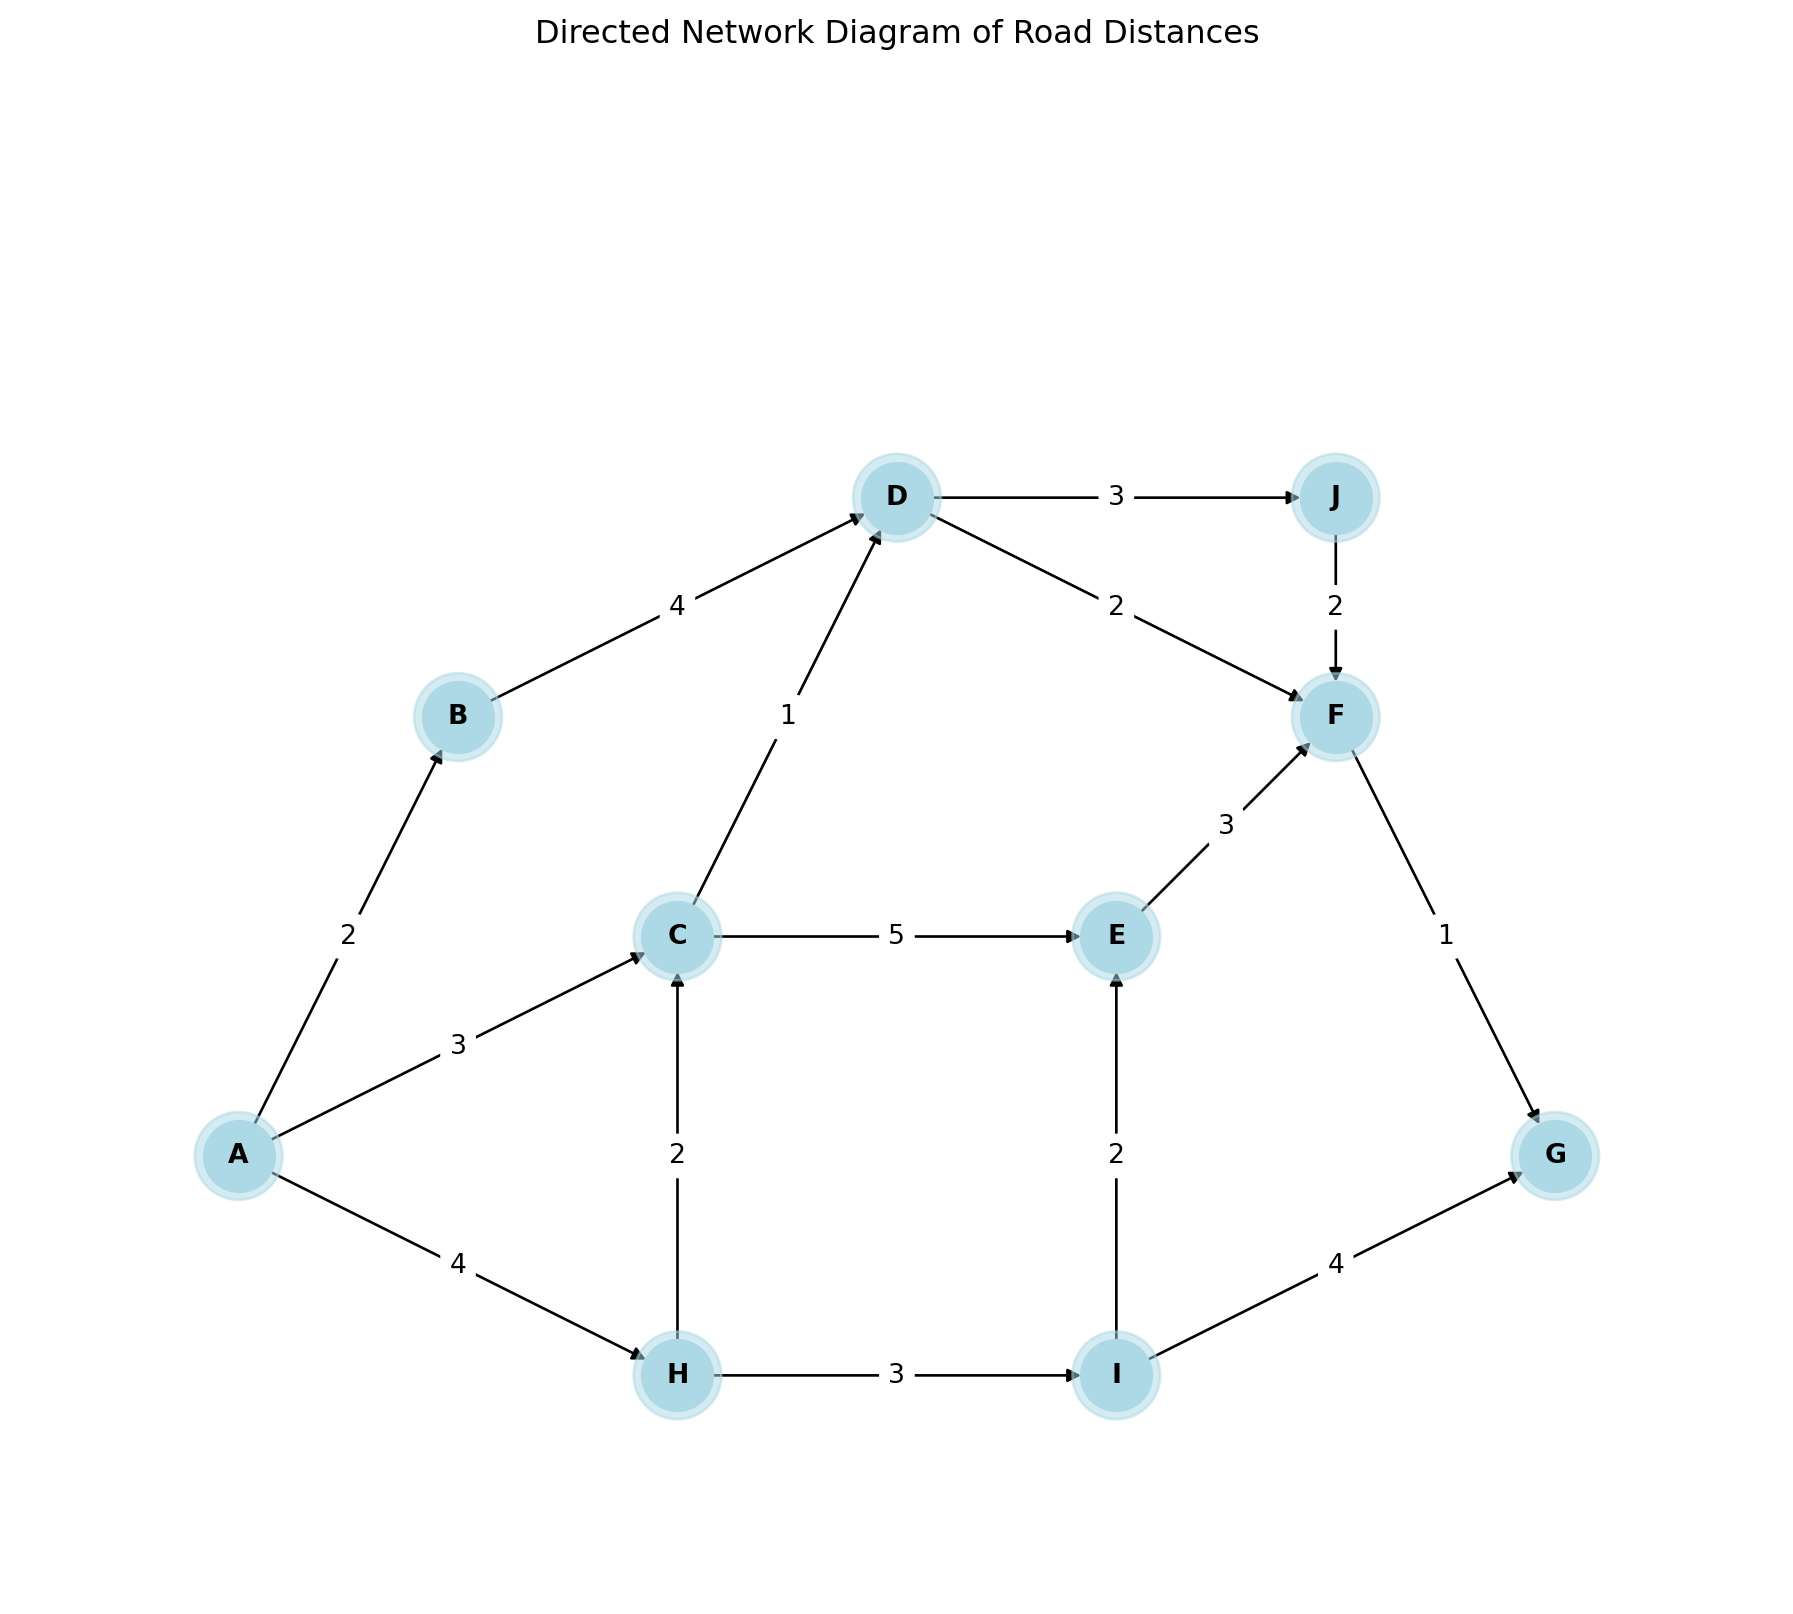

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# Create a new directed graph
G = nx.DiGraph()

# Add nodes with positions
positions = {
    'A': (0, 0),
    'B': (1, 2),
    'C': (2, 1),
    'D': (3, 3),
    'E': (4, 1),
    'F': (5, 2),
    'G': (6, 0),
    'H': (2, -1),
    'I': (4, -1),
    'J': (5, 3)
}

# Add edges with weights
edges = [
    ('A', 'B', 2, 0.001),
    ('A', 'C', 3, 0.002),
    ('B', 'D', 4, 0.003),
    ('C', 'D', 1, 0.001),
    ('C', 'E', 5, 0.001),
    ('D', 'F', 2, 0.005),
    ('E', 'F', 3, 0.002),
    ('F', 'G', 1, 0.010),
    ('A', 'H', 4, 0.008),
    ('H', 'C', 2, 0.006),
    ('H', 'I', 3, 0.002),
    ('I', 'E', 2, 0.001),
    ('I', 'G', 4, 0.002),
    ('D', 'J', 3, 0.002),
    ('J', 'F', 2, 0.008)
]

# Add the edges to the graph
for u, v, w, prob in edges:
    G.add_edge(u, v, Distance=w, Probability=prob)

# Draw the updated graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'Distance')

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, rotate=False)

# Draw circles around nodes
for node, (x, y) in positions.items():
    circle = mpatches.Circle((x, y), radius=0.2, color='lightblue', alpha=0.5)
    plt.gca().add_patch(circle)

# Set limits and aspect
plt.xlim(-1, 7)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Directed Network Diagram of Road Distances')
plt.grid()
plt.show()

In [3]:
# Create a pandas DataFrame to store the edges and their attributes

import pandas as pd
# Create a DataFrame from the edges list
dt = pd.DataFrame(edges, columns=['Source', 'Target', 'Distance', 'Probability']).set_index(['Source', 'Target'])
# Display the DataFrame

dt

Distance  Probability
Source Target                       
A      B              2        0.001
       C              3        0.002
B      D              4        0.003
C      D              1        0.001
       E              5        0.001
D      F              2        0.005
E      F              3        0.002
F      G              1        0.010
A      H              4        0.008
H      C              2        0.006
       I              3        0.002
I      E              2        0.001
       G              4        0.002
D      J              3        0.002
J      F              2        0.008

In [4]:
# Get all unique values from a multiindex
def get_unique_values(df):
    # Get the unique values from the multiindex
    unique_values = set()
    for index in df.index:
        unique_values.update(index)
    return unique_values

nodes = get_unique_values(dt)

nodes

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'}

In [5]:
# A gurobi optimization model for the shortest path problem

import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("ShortestPath")

# Create variables for each edge
x = m.addVars(dt.index, vtype=GRB.BINARY, name="x")

# Set the objective function to minimize the total distance
m.setObjective(x.prod(dt['Distance'].to_dict()), GRB.MINIMIZE)

# Add constraints to ensure that the flow conservation is satisfied

# For each node, the flow into the node must equal the flow out of the node

for node in nodes:
    if node == 'A':  # Source node
        m.addConstr(x.sum(node, '*') == 1, name=f"source_{node}")
    elif node == 'G':  # Sink node
        m.addConstr(x.sum('*', node) == 1, name=f"sink_{node}")
    else:
        m.addConstr(x.sum(node, '*') == x.sum('*', node), name=f"flow_{node}")
        m.addConstr(x.sum(node, '*') <= 1, name=f"outflow_{node}")
        m.addConstr(x.sum('*', node) <= 1, name=f"infow_{node}")

# Add constraints to ensure that the flow is binary

m.write("shortest_path.lp")

with open("shortest_path.lp", "r") as file:
    print(file.read())

m.optimize()

Restricted license - for non-production use only - expires 2027-11-29


\ Model ShortestPath
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  2 x[A,B] + 3 x[A,C] + 4 x[B,D] + x[C,D] + 5 x[C,E] + 2 x[D,F] + 3 x[E,F]
   + x[F,G] + 4 x[A,H] + 2 x[H,C] + 3 x[H,I] + 2 x[I,E] + 4 x[I,G]
   + 3 x[D,J] + 2 x[J,F]
Subject To
 source_A: x[A,B] + x[A,C] + x[A,H] = 1
 flow_D: - x[B,D] - x[C,D] + x[D,F] + x[D,J] = 0
 outflow_D: x[D,F] + x[D,J] <= 1
 infow_D: x[B,D] + x[C,D] <= 1
 flow_C: - x[A,C] + x[C,D] + x[C,E] - x[H,C] = 0
 outflow_C: x[C,D] + x[C,E] <= 1
 infow_C: x[A,C] + x[H,C] <= 1
 flow_H: - x[A,H] + x[H,C] + x[H,I] = 0
 outflow_H: x[H,C] + x[H,I] <= 1
 infow_H: x[A,H] <= 1
 flow_B: - x[A,B] + x[B,D] = 0
 outflow_B: x[B,D] <= 1
 infow_B: x[A,B] <= 1
 flow_E: - x[C,E] + x[E,F] - x[I,E] = 0
 outflow_E: x[E,F] <= 1
 infow_E: x[C,E] + x[I,E] <= 1
 flow_J: - x[D,J] + x[J,F] = 0
 outflow_J: x[J,F] <= 1
 infow_J: x[D,J] <= 1
 flow_I: - x[H,I] + x[I,E] + x[I,G] = 0
 outflow_I: x[I,E] + x[I,G] <= 1
 infow_I: x[H,I] <= 1
 sink_G:

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 26 rows, 15 columns and 55 nonzeros (Min)


Model fingerprint: 0xe553d214


Model has 15 linear objective coefficients


Variable types: 0 continuous, 15 integer (15 binary)


Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 5e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+00]


Found heuristic solution: objective 7.0000000


Presolve removed 26 rows and 15 columns


Presolve time: 0.00s


Presolve: All rows and columns removed


Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)


Thread count was 1 (of 32 available processors)


Solution count 1: 7 


Optimal solution found (tolerance 1.00e-04)


Best objective 7.000000000000e+00, best bound 7.000000000000e+00, gap 0.0000%


In [6]:
# Print the results

if m.status == GRB.OPTIMAL:
    print('Optimal solution found:')
    for v in m.getVars():
        if v.x > 0:
            print(f'{v.varName}: {v.x}')

    print(f'Objective value: {m.objVal}')
else:
    print('No optimal solution found.')


Optimal solution found:
x[A,C]: 1.0
x[C,D]: 1.0
x[D,F]: 1.0
x[F,G]: 1.0
Objective value: 7.0


Nun hat der Fahrer seine optimale Route gefunden. Allerdings kümmert er sich auch um die Sicherheit seiner Fahrt. Deswegen hat er auch Daten über die Häufigkeit von Autounfällen auf den Straßen gesammelt. Er bewertet die Straßen mit den folgenden Werten, die die Wahrscheinlichket eines Unfalls darstellen (die Spalte `Probability` in dem Datensatz `dt`). Nun möchte unser Fahrer die sicherste Route finden, d.h. diejenige wo die Wahrscheinlichkeit für keinen Unfall am höchsten ist. Wir wollen ein lineares Modell formulieren, das dieses Problem löst. Wir nehmen an, dass die Unfälle auf den einzelnen Strassen unabhängig voneinander passieren.

- Was ist die Wahrscheinlichkeit, dass auf der gewählten Route kein Unfall passiert?
- Wie sieht die optimale Route aus?
- Wie häufig soll der Fahrer einen Unfall erwarten, wenn er die Route zwei mal am Tag über fünf Jahre fährt?
- Wie lang ist die sicherste Route?

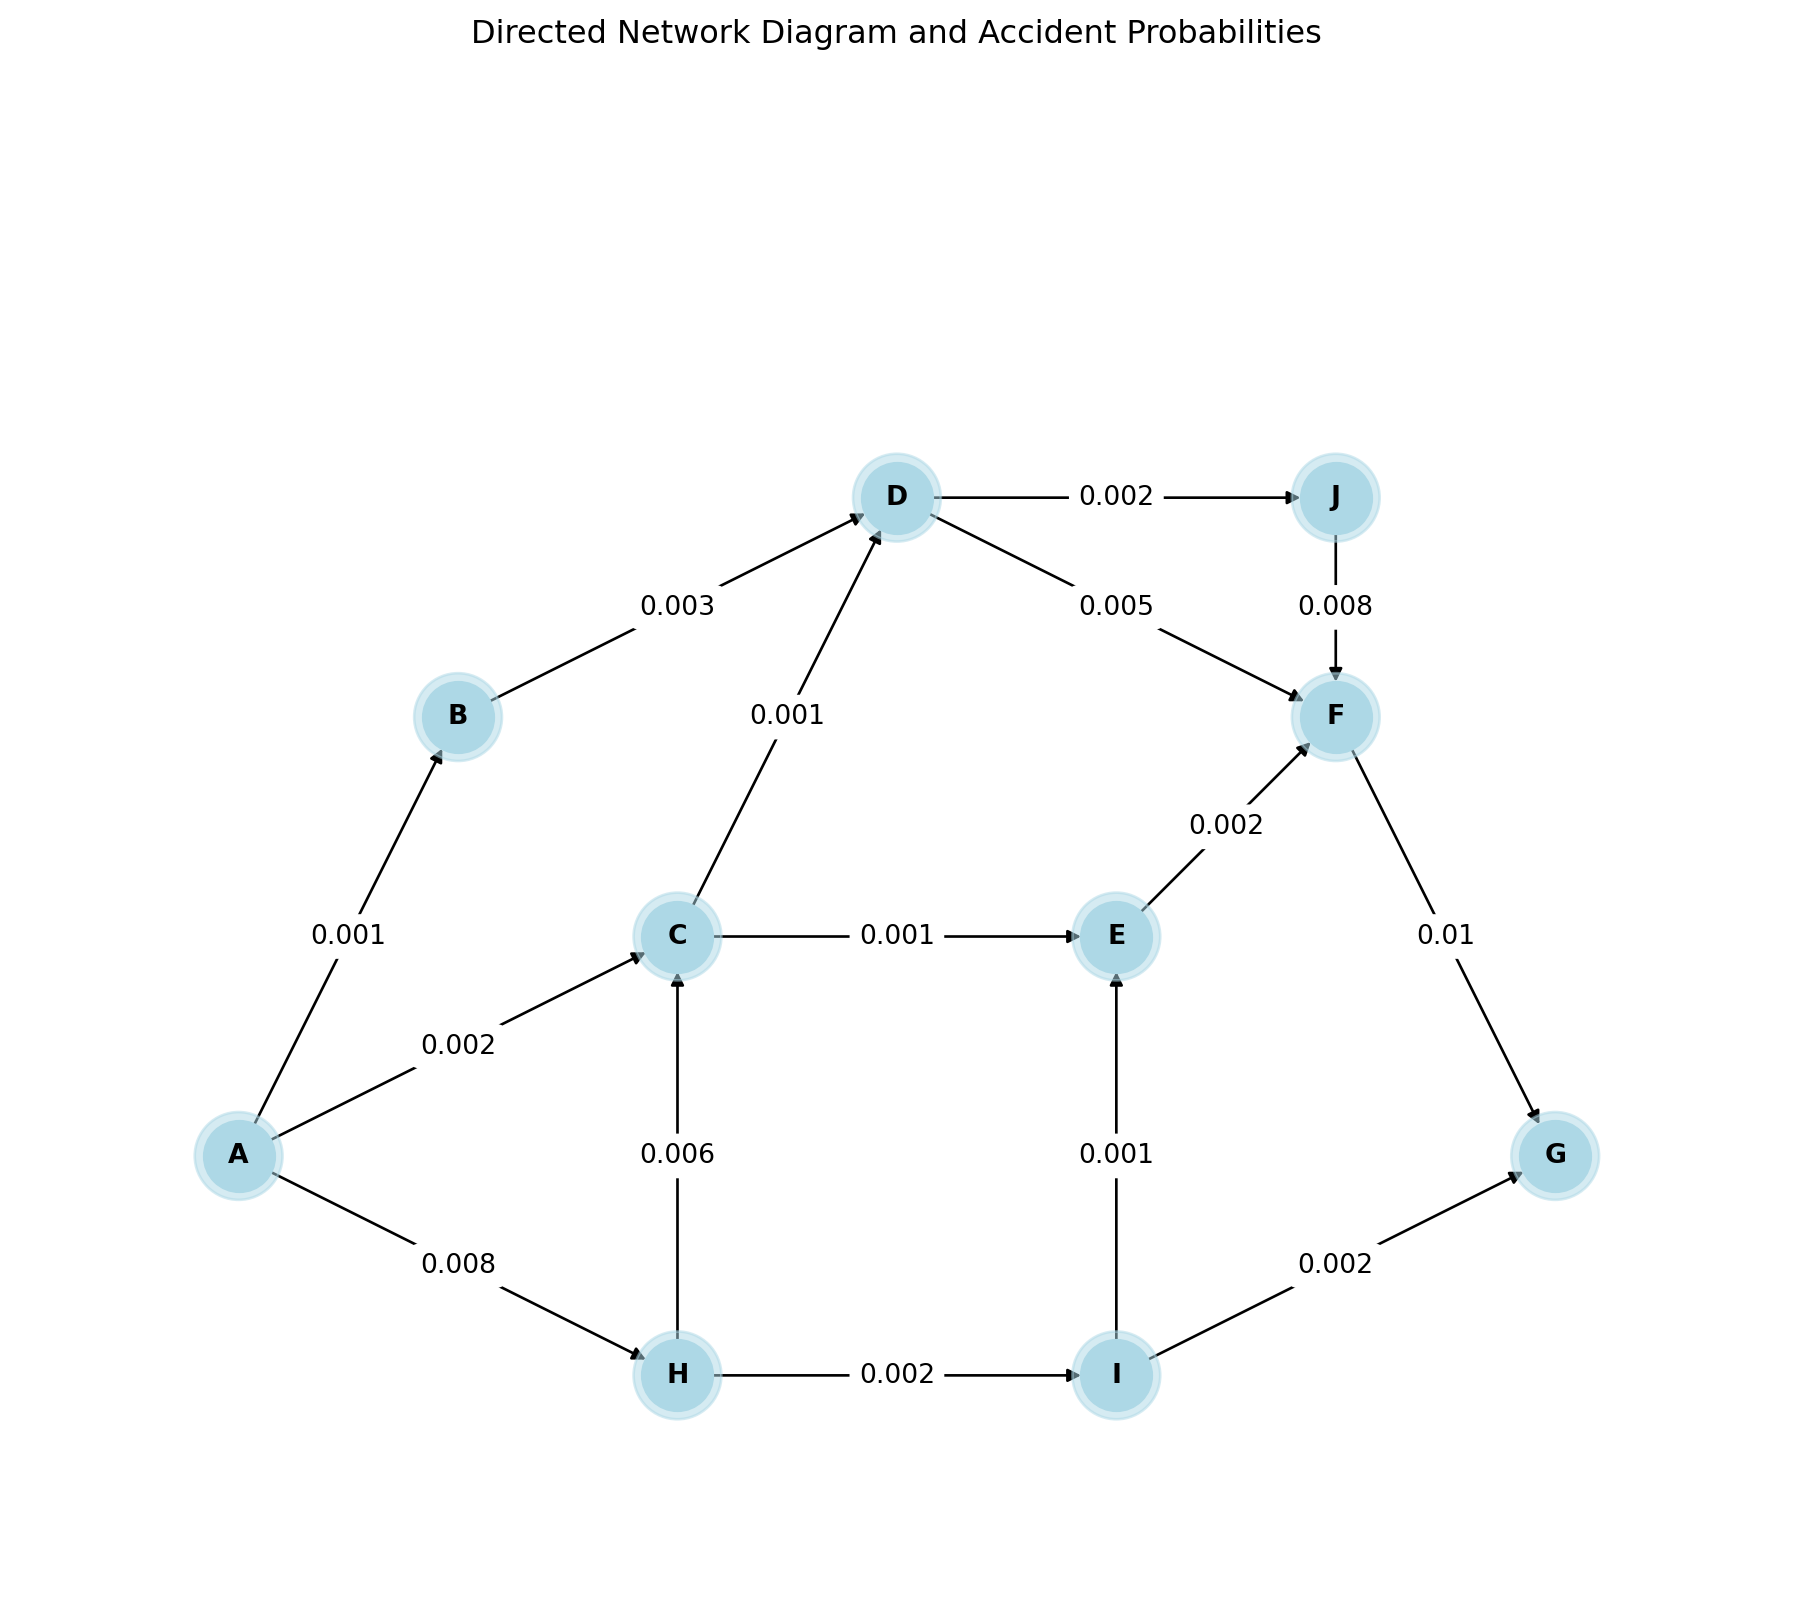

In [7]:
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'Probability')

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, rotate=False)

# Draw circles around nodes
for node, (x, y) in positions.items():
    circle = mpatches.Circle((x, y), radius=0.2, color='lightblue', alpha=0.5)
    plt.gca().add_patch(circle)

# Set limits and aspect
plt.xlim(-1, 7)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Directed Network Diagram and Accident Probabilities')
plt.grid()
plt.show()

Wir möchten die sicherste Route finden. Das bedeutet, daß die Wahrscheinlichkeit, **keinen** Unfall zu haben, maximiert werden soll. In dem Datensatz haben wir Wahrscheinlichkeiten für das Ereignis "Unfall" auf den einzelnen Straßen.

Bezeichnen wir mit $P(A_{s,e})$ die Wahrscheinlichkeiten, einen Unfall auf der Stracke mit Anfang $s$ und Ende $e$ zu haben. Die Unfälle passieren unabhängig auf den verschiedenen Strecken, deswegen ist die Wahrscheinlichkeit, **keinen** Unfall zu haben, das Produkt der Wahrscheinlichkeiten, **keinen** Unfall auf der einzelnen Strecke zu haben. 



In [8]:
probs = np.array([0.008, 0.002, 0.002])
np.exp(np.log((1 - probs)).sum())

np.float64(0.988035968)

In [9]:
# Create a new model


m1 = gp.Model("ShortestPath with Accident Probabilities")

m1.write("safest_path.lp")
with open("safest_path.lp", "r") as file:
    print(file.read())

m1.optimize()


\ Model ShortestPath with Accident Probabilities
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 
Subject To
Bounds
End

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64 - "Ubuntu 24.04.4 LTS")


CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 0 rows, 0 columns and 0 nonzeros (Min)


Model fingerprint: 0xf9715da1


Model has 0 linear objective coefficients


Coefficient statistics:


  Matrix range     [0e+00, 0e+00]


  Objective range  [0e+00, 0e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [0e+00, 0e+00]


Presolve time: 0.00s


Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s


Solved in 0 iterations and 0.00 seconds (0.00 work units)


Optimal objective  0.000000000e+00


In [10]:
# Print the results

if m1.status == GRB.OPTIMAL:
    print('Optimal solution found:')
    for v in m1.getVars():
        if v.x > 0:
            print(f'{v.varName}: {v.x}')
else:
    print('No optimal solution found.')

Optimal solution found:
